# Modelo de TF-IDF

In [ ]:
!pip install SpeechRecognition
!pip install soundfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#class read_txt.py


In [ ]:
#Create dateFrame
def read(path):
  nltk.download('stopwords')

  stop = stopwords.words('english')

  #Apply latin encode
  df = pd.read_csv(path, encoding='latin1') 


  #Change text to lowercase
  df = df.applymap(str.lower) 
  
  return df

#class ContentAnalyzer.py

In [ ]:
#Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import train_test_split

from joblib import dump
from gensim.parsing.preprocessing import remove_stopwords

#Speech recognition
import speech_recognition as sr
import soundfile as sf

#Pandas & Pumpy
import pandas as pd
import numpy as np

#Stopwords
import nltk
from nltk.corpus import stopwords
#Punctuation characters
# from string import punctuation
# import re
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
# nltk.download('punkt')

#Graphics and plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import make_pipeline

#
# Class used to pass from a speech to text,
# and analyze the content of it
#
class ContentAnalyzer():

    #Constructor class 

    #Class Atributes: 
      # txt_path            =   Path to news
      # path_model          =   Path to save the model
      # dataset             =   dataset loaded
        #self.dataset[0] = Train dataset
        #self.dataset[1] = Test dataset
        #self.dataset[2] = Validation dataset
      # text_clf            =   Pipeline Object to store the several parts
      # categories          =   Auxiliar array to know the characteristics
      # correct_predictions =   Auxiliar array to store the correct predictions of the model.

    def __init__(self, path_model, txt_path, categories):
        
        self.txt_path = txt_path
        self.path_model = path_model
        self.dataset = None
        self.text_clf = None
        self.categories = categories
        self.correctPredictions = [0] * len(self.categories)
        self.accuracy = 0.0

    # Training method
    # dataset_part : It can be either the combination X_train - Y_train or X_test - Y_test
    def fit(self, dataset_part, selection_val=0):
      #Versión por defecto: Entrena 3 modelos (+Coste)
      if(selection_val == 0):
        self.fit_neighbors(dataset_part, 20)
        self.describe()

        self.fit_NB(dataset_part)
        self.eval_NB(self.dataset[1])
        self.describe()

        self.fit_SGDC(train_dataset)
        self.eval_NB(self.dataset[1])
        self.describe()
      #Versiones reducidas
      # 1: Vecinos con 20 vecinos
      # 2: Naive Bayes
      # 3: SGDC
      if(selection_val == 1):
        self.fit_neighbors(dataset_part, 20)
        self.describe()
      if(selection_val == 2):
        self.fit_NB(dataset_part)
        self.eval_NB(self.dataset[1])
        self.describe()
      if(selection_val == 3):
        self.fit_SGDC(train_dataset)
        self.eval_NB(self.dataset[1])
        self.describe()

    def fit_neighbors(self, dataset_part, neighbors):

        #Count Words
        count_vect = CountVectorizer()

        #Arrays: 0 training, 1 testing
        #X_train_counts = count_vect.fit_transform(dataset_part.head(dataset_part.size))  
        X_train_counts = count_vect.fit_transform(dataset_part.news)  
        #Transform by ocurrency
        tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
        X_train_tf = tf_transformer.transform(X_train_counts)

        
        #Trasform to ocurrency and weight
        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

        #Classifier
        clf = KNeighborsClassifier(n_neighbors=neighbors)       
               
        #Pipelined to work better in the predict work
        
        text_clf = Pipeline([
            ('vect', count_vect),
            ('tfidf', tfidf_transformer),
            ('clf', clf),
            ])
        
        # Fit the text classifier
        text_clf.fit(dataset_part.news, dataset_part.intCategory)
        self.text_clf = text_clf

    #Method fit with Naive Bayes
    def fit_NB(self,train_dataset,alphaParam):
      count_vect = CountVectorizer()
      X_train_counts = count_vect.fit_transform(train_dataset.news)
      X_train_counts.shape

      tfidf_transformer = TfidfTransformer()
      X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
      X_train_tfidf.shape
      
      clf = MultinomialNB().fit(X_train_tfidf, train_dataset.intCategory.to_numpy())

      text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=alphaParam))])
      #Pipelined to work better in the predict work
      text_clf = text_clf.fit(train_dataset.news, train_dataset.intCategory.to_numpy())
      
      self.text_clf = text_clf
      
    #Method fit with SGDClassifier
    def fit_SGDC(self,train_dataset,lossParam,alphaParam,learning_rateParam):
      count_vect = CountVectorizer()
      X_train_counts = count_vect.fit_transform(train_dataset.news)
      X_train_counts.shape

      tfidf_transformer = TfidfTransformer()
      X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
      X_train_tfidf.shape

      clf = MultinomialNB().fit(X_train_tfidf, train_dataset.intCategory.to_numpy())
      #Pipelined to work better in the predict work
      text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss=lossParam, penalty='l2',alpha=alphaParam, 
                                                                                                               random_state=42,learning_rate=learning_rateParam))])

      text_clf = text_clf.fit(train_dataset.news, train_dataset.intCategory.to_numpy())

      self.text_clf = text_clf  

    def eval_NB(self,test_dataset):     
      predicted = self.text_clf.predict(test_dataset.news)
      resultado = np.mean(predicted == test_dataset.intCategory.to_numpy())


    #Text-driven prediction method
    def predict(self, list_news):

        if self.text_clf == None:
          #Modelo no entrenado
          text_clf = self.fit(self.dataset[0])

        #Modelo ya entrenado
        text_clf = self.text_clf
      
        #Applying the count vectorizer
        X_new_counts = text_clf[0].transform(list_news)

        #Applying the tf-idf transformer
        X_new_tfidf = text_clf[1].transform(X_new_counts)

        #Predicting the resullt
        predicted = text_clf[2].predict(X_new_tfidf)
      
        for doc, category in zip(list_news, predicted):     
            return self.categories[category]


    #Method to print the input text and its category
    def print_predict(self,news):
      return'{} => {}'.format(news[0],  self.predict(news))

    #    Audio-driven prediction method
    #    x: audioFile
    #
    def predict_audio(self,sound):
        r = sr.Recognizer()
       
        with sr.AudioFile(sound) as source:
            r.adjust_for_ambient_noise(source)
            audio = r.record(source)
            
            try:
                print(self.print_predict([r.recognize_google(audio)]))
                
            except Exception as e: 
                print(e)

    #Method that stores the model created into a path
    def store(self, path_model):
        try:
            dump(self.text_clf[2], path_model)
        except Exception as e:
            print(e)

    #Method to evaluate the model on which we are working
    #TODO: with val_data -> test_data

        #self.dataset[0] = Train dataset
        #self.dataset[1] = Test dataset
        #self.dataset[2] = Validation dataset
    def eval(self,testDataset):
        #Metric used: Accuracy (correctly predicted class / total testing class) × 100%
        news = testDataset.shape
        correctPredict = 0
        prediccion = " "
        data = testDataset
        self.correctPredictions = [0] * len(self.categories)

        for col in data.index:
          newCategory = data.loc[ col , 'category']
          newToPredict = data.loc[ col , 'news' ]
          prediction = self.predict([newToPredict])

          if newCategory == prediction:
            correctPredict+=1
            self.correctPredictions[data.loc[col, 'intCategory']] +=1 
        self.accuracy = (correctPredict / news[0]) * 100
        return (correctPredict / news[0]) * 100

    #toString method to describe the result
    def describe(self):
        print("##### Describe #####")
        print("Dataset path: "+ self.txt_path)
        print("\n")

        print("### Train ###")
        print("Shape:"+ str(self.dataset[0].shape))
        trainSerie = self.getNewsDistribution(self.dataset[0])
        print(trainSerie)   
        print("\n")

        print("### Test ###")
        print("Shape:"+ str(self.dataset[1].shape))
        testSerie = self.getNewsDistribution(self.dataset[1])
        print(testSerie)  
        print("\n")

        print("### Validation ###")
        print("Shape:"+ str(self.dataset[2].shape))
        valSerie = self.getNewsDistribution(self.dataset[2])
        print(valSerie)
        print("\n")
        
        print("Error:" + str(self.eval(self.dataset[1])))
        self.overall_distribution_plot(trainSerie, testSerie, valSerie)
        self.dataset_distribution_plot(trainSerie, testSerie, valSerie)
        self.accuracy_plot(testSerie)

    #Method to get the news distribution of a dataset by category
    def getNewsDistribution(self,dataset):
      return dataset[['category']].value_counts(sort=False)

    #Method to get the numerical of a type 
    #This is needed by the method fit, which requires the numerical types of the categories
    def getNumericalType(self,speech_dataset):
        categories = self.categories
        final = list()

        for x in speech_dataset.category:
          final.append(categories.index(x))
         
        return final
      
    #Aux method to remove stowords from a text
    def quitarStopWords(self, text):
      stop = stopwords.words('english')
      text_tokens = word_tokenize(text)
      tokens_without_sw = [word for word in text_tokens if not word in stop]
      filtered_sentence = (" ").join(tokens_without_sw)
      
      return filtered_sentence

    #Method that process the data before it enters to the training
    #Scope: Private
    def _preprocess_data(self, x):
       #speech_dataset has now 2 columns: news : categories
       #For prediction, we also need to asign a number to each type, to have a integer indexation

        #List with all English stopwords and punctuation characters
        stop = stopwords.words('english')

        #Apply latin encode (special characters)
        df = pd.read_csv(self.txt_path, encoding='latin1')

        #Delete stopwords and punctuation characters
        #df = df.applymap(self.quitarStopWords)
        df = df.applymap(remove_stopwords)
        df['news'] = df['news'].str.replace('[^\w\s]','')
      
        #Change text to lowercase
        df = df.applymap(str.lower) 
        speech_dataset = df

        business_i = self.getNumericalType(speech_dataset)


        speech_dataset = speech_dataset.assign(intCategory = business_i)
        
        #Create train,validation and test datasets 
        speech_train, speech_val_data, speech_test = np.split(speech_dataset.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
       

        #speech_train, speech_test= train_test_split(speech_dataset, test_size=0.25) #Split the dataset into two. Text and train
        #self.dataset[0] = Train dataset
        #self.dataset[1] = Test dataset
        #self.dataset[2] = Validation dataset
        self.dataset = [speech_train, speech_test,speech_val_data]

        return self.dataset

    #Method to load a propocessed dataset
    def setPrepocessDataset(self,preprocessData):
      self.dataset = preprocessData

    ##########################################
    # Plots of news distribution by category #
    ##########################################
    def overall_distribution_plot(self, trainSerie, testSerie, valSerie):
        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

        #Create plot
        df = pd.DataFrame({'Categories':self.categories , 'News amount':valSerie.values + testSerie.values + trainSerie.values})
        df.plot.bar(ax=axes, title ='News dataset distribution',color={"#32a8a0"})

        #Asing labels to each bar
        axes.set_xticklabels(df['Categories'], rotation=0)

        totalCategories = [0]* len(trainSerie.values)
        for x in range(len(trainSerie.values)):
          totalCategories[x] = testSerie.values[x] + valSerie.values[x] + trainSerie.values[x]
        print("Distrubución total por categorias: "+ str(totalCategories))


    ###################################################
    # Plots of datasets news distribution by category #
    ###################################################
    def dataset_distribution_plot(self, trainSerie, testSerie, valSerie):

      fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18,5))

      # #Plot that shows the news distribution of Train Dataset 
      trainSerie = self.getNewsDistribution(self.dataset[0])
      df = pd.DataFrame({'Categories':categorias, 'News amount':trainSerie.values})

      df.plot.bar(ax=axes[0],title ='Train Dataset Distribution',color={"#6a06bd"})

      #Plot that shows the news distribution of Test Dataset
      testSerie = self.getNewsDistribution(self.dataset[1])
      df = pd.DataFrame({'Categories':categorias , 'News amount':testSerie.values})

      df.plot.bar(ax=axes[1],title ='Test Dataset Distribution',color={"#fcb103"})

      #Plot that shows the news distribution of Validation Dataset 
      valSerie = self.getNewsDistribution(self.dataset[2])
      df = pd.DataFrame({'Categories':categorias , 'News amount':valSerie.values})

      df.plot.bar(ax=axes[2], title ='Validation Dataset Distribution',color={"#03fca1"})

      #Asing labels to each bar
      axes[0].set_xticklabels(df['Categories'], rotation=0)
      axes[1].set_xticklabels(df['Categories'], rotation=0)
      axes[2].set_xticklabels(df['Categories'], rotation=0)


    ##########################################
    # Plots of accuracy by category          #
    ##########################################
    def accuracy_plot(self, testSerie):
      figure(figsize=(8,8))
      #Set height of bar

      #bars1 = a.tamNews
      bars1 = testSerie
      bars2 = self.correctPredictions

      #Set position of bar on X axis
      barWidth = 0.4
      r1 = np.arange(len(bars1))
      r2 = [x + barWidth for x in r1]
      
      #Make the plot
      plt.bar(r1, bars1, color='#4287f5', width=barWidth, edgecolor='white', label='News amount')
      plt.bar(r2, bars2, color='#42e9f5', width=barWidth, edgecolor='white', label='Correctly predicted news')


      #Add xticks on the middle of the group bars
      plt.title('Accuracy')
      plt.xticks([r + barWidth for r in range(len(bars1))], self.categories)

      # Create legend & Show graphic
      plt.legend()
      plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#txt_path = '/content/drive/MyDrive/Cuarto/practicas_externas/Proyecto/news.txt' #Path Raul
txt_path = '/content/novelasOro_Zayas.txt'
#txt_path = '/content/drive/MyDrive/Cuarto/practicas_externas/Proyecto/newsCNNsmall.txt'
audio1_path = '/content/drive/MyDrive/Cuarto/practicas_externas/Proyecto/audios/audio_001.wav' #Path Raul
audio2_path = '/content/drive/MyDrive/Cuarto/practicas_externas/Proyecto/audios/audio_002.wav' #Path Raul

#Create dataframe to get unique categories
df = read(txt_path)

categorias = df.category.unique()
categorias =categorias.tolist()
print(df)

#txt_path = '/content/news.txt'
#audio1_path = '/content/audioRafa.wav'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                                    news        category
0      agustín de rojas villandrando el viaje entrete...  agustinderojas
1       y para que de ello conste de pedimiento de la...  agustinderojas
2       y mandamos al impresor que ansí imprimiere el...  agustinderojas
3       juan de amezqueta. privilegio   don felipe po...  agustinderojas
4       en testimonio de lo cual mandamos despachar l...  agustinderojas
...                                                  ...             ...
15463   otros decían que había andado atrevida en dar...           zayas
15464   todo esto traía a don pedro avergonzado y con...           zayas
15465   vino a ser tan pública esta amistad que la ci...           zayas
15466   mas de dos meses aguardó el falso don pedro l...           zayas
15467   ¿adónde te has ido decía amada esposa mía?...           zayas

[154

In [ ]:
# Model creation #
modeloTfidf = ContentAnalyzer("model.joblib", txt_path, categorias)

In [ ]:
# Data preprocessing #
preprocessDataset = modeloTfidf._preprocess_data(txt_path)

In [ ]:
print(type(preprocessDataset))

<class 'list'>


In [ ]:
# Preprocessed data #
modeloTfidf.setPrepocessDataset(preprocessDataset)

train_dataset = modeloTfidf.dataset[0]
test_dataset = modeloTfidf.dataset[2]

In [ ]:
#Save in an array every accuracy rate
accuracy = list()

##### Describe #####
Dataset path: /content/novelasOro_Zayas.txt


### Train ###
Shape:(9280, 3)
category        
agustinderojas       482
avellaneda           343
carvajal             258
castillo             326
cervantes           2045
cervantessalazar     540
frayluisdeleon       525
lazarillo            151
lope                 669
mateoaleman          467
mendoza              125
montalban            134
otalora              772
pasamonte            205
suarezfigueroa       699
tirso                265
ubeda                511
valdes               464
zayas                299
dtype: int64


### Test ###
Shape:(3094, 3)
category        
agustinderojas      169
avellaneda           91
carvajal             71
castillo            102
cervantes           723
cervantessalazar    175
frayluisdeleon      193
lazarillo            50
lope                213
mateoaleman         173
mendoza              48
montalban            40
otalora             241
pasamonte            69
suarezfigueroa

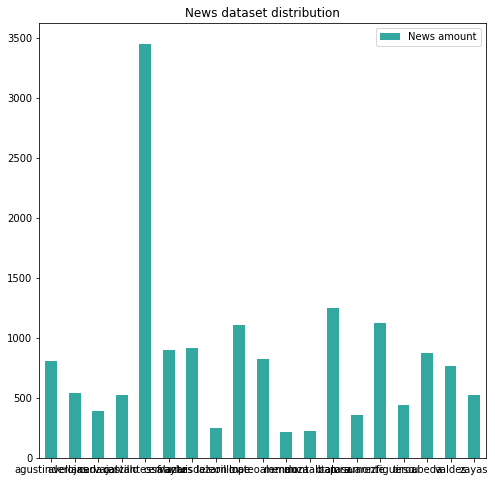

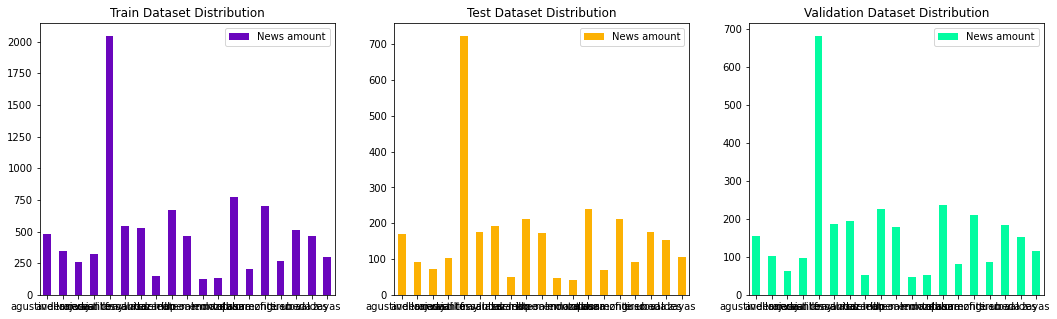

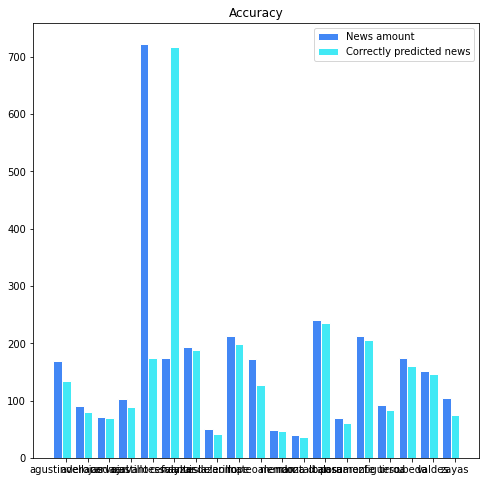

In [ ]:
# SGDC #

# or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.
loss= 'epsilon_insensitive' 

#Constant that multiplies the regularization term. The higher the value, the stronger the regularization. 
#Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
alpha= 0.0001
#‘constant’: eta = eta0
#‘optimal’: eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou.
#‘invscaling’: eta = eta0 / pow(t, power_t)
# ‘adaptive’: eta = eta0, as long as the training keeps decreasing. Each time n_iter_no_change consecutive epochs 
# fail to decrease the training loss by tol or fail to increase validation score by tol if early_stopping is True, 
# the current learning rate is divided by 5.

learning_rate = 'optimal'
modeloTfidf.fit_SGDC(train_dataset,loss,alpha,learning_rate)
modeloTfidf.eval_NB(test_dataset)
modeloTfidf.describe()

accuracy.append(modeloTfidf.accuracy)

##### Describe #####
Dataset path: /content/novelasOro_Zayas.txt


### Train ###
Shape:(9280, 3)
category        
agustinderojas       482
avellaneda           343
carvajal             258
castillo             326
cervantes           2045
cervantessalazar     540
frayluisdeleon       525
lazarillo            151
lope                 669
mateoaleman          467
mendoza              125
montalban            134
otalora              772
pasamonte            205
suarezfigueroa       699
tirso                265
ubeda                511
valdes               464
zayas                299
dtype: int64


### Test ###
Shape:(3094, 3)
category        
agustinderojas      169
avellaneda           91
carvajal             71
castillo            102
cervantes           723
cervantessalazar    175
frayluisdeleon      193
lazarillo            50
lope                213
mateoaleman         173
mendoza              48
montalban            40
otalora             241
pasamonte            69
suarezfigueroa

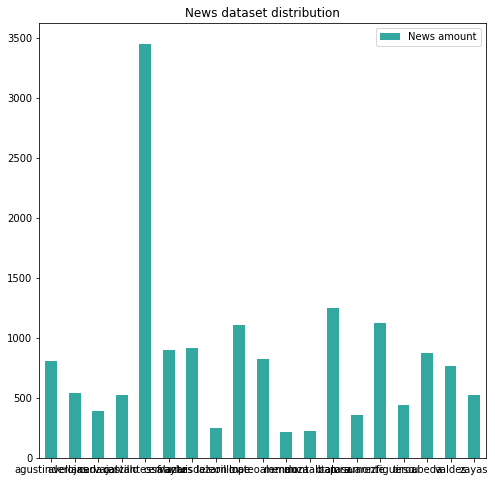

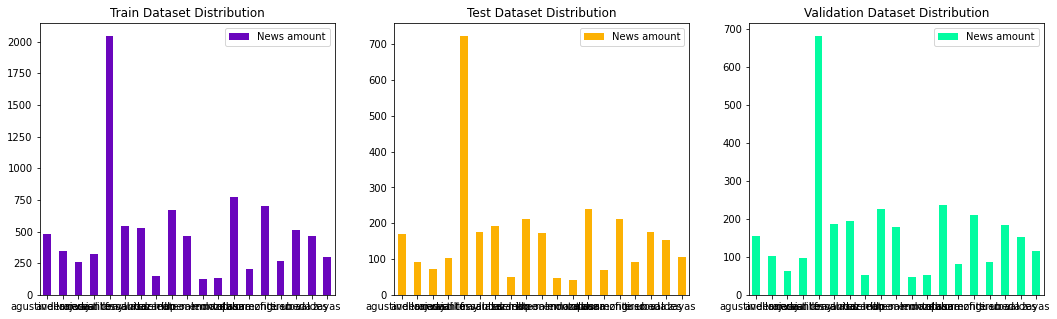

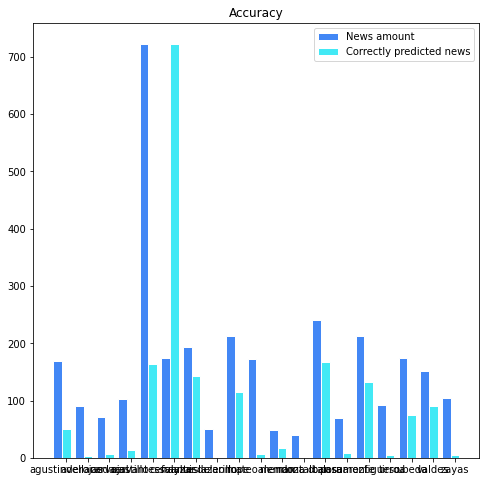

In [ ]:
# Naive Bayes #

alpha= 0.1
modeloTfidf.fit_NB(train_dataset,alpha)
modeloTfidf.eval_NB(test_dataset)
modeloTfidf.describe()

accuracy.append(modeloTfidf.accuracy)

##### Describe #####
Dataset path: /content/novelasOro_Zayas.txt


### Train ###
Shape:(9280, 3)
category        
agustinderojas       482
avellaneda           343
carvajal             258
castillo             326
cervantes           2045
cervantessalazar     540
frayluisdeleon       525
lazarillo            151
lope                 669
mateoaleman          467
mendoza              125
montalban            134
otalora              772
pasamonte            205
suarezfigueroa       699
tirso                265
ubeda                511
valdes               464
zayas                299
dtype: int64


### Test ###
Shape:(3094, 3)
category        
agustinderojas      169
avellaneda           91
carvajal             71
castillo            102
cervantes           723
cervantessalazar    175
frayluisdeleon      193
lazarillo            50
lope                213
mateoaleman         173
mendoza              48
montalban            40
otalora             241
pasamonte            69
suarezfigueroa

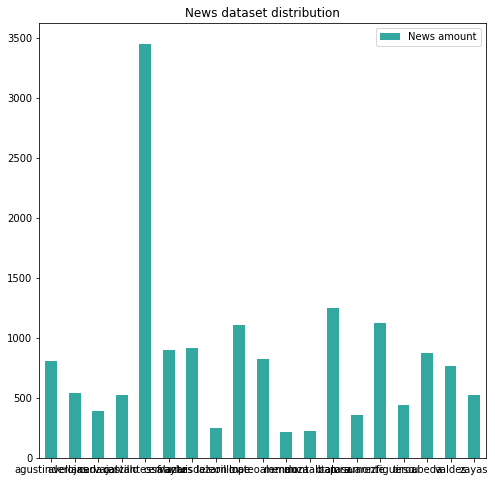

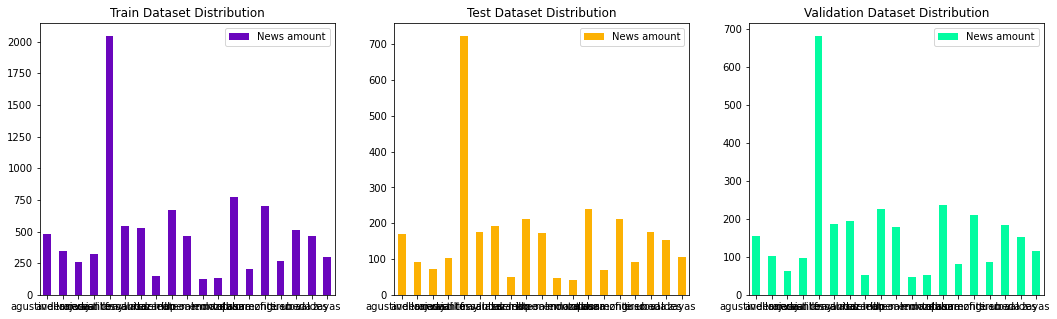

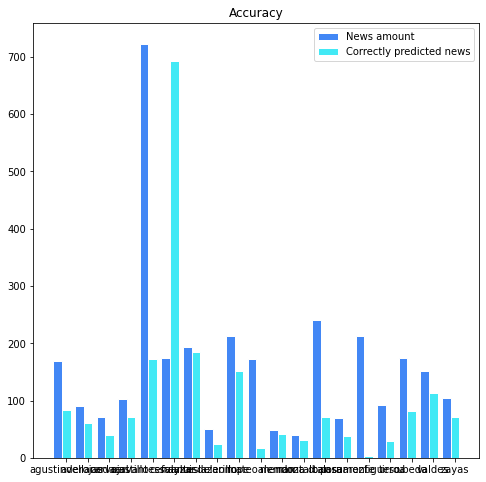

In [ ]:
# KNN #

modeloTfidf.fit_neighbors(modeloTfidf.dataset[0],10)

modeloTfidf.describe()

accuracy.append(modeloTfidf.accuracy)

[Text(0, 0, 'SGDC'), Text(0, 0, 'Naive-Bayes'), Text(0, 0, 'KNN')]

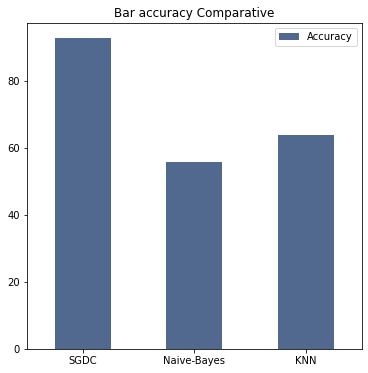

In [ ]:
#Accuracy
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,6))

models = ["SGDC", "Naive-Bayes", "KNN"]
df = pd.DataFrame({'Models':models , 'Accuracy': accuracy})
df.plot.bar(ax=axes, title ='Bar accuracy Comparative',color={"#51698f"})

axes.set_xticklabels(models, rotation=0)

Examples

In [ ]:
modeloTfidf.print_predict(["How to be the president of the United States of America."])

'How to be the president of the United States of America. => avellaneda'

In [ ]:
modeloTfidf.print_predict(['The match was played in the field of Manchester United. Anthony Martial scored the lonely goal of the night'])  

'The match was played in the field of Manchester United. Anthony Martial scored the lonely goal of the night => otalora'

In [ ]:
modeloTfidf.print_predict(['The TESLA actions have fluctuated in this period. They are not gonna be profitable'])

'The TESLA actions have fluctuated in this period. They are not gonna be profitable => otalora'

In [ ]:
modeloTfidf.print_predict(['The Simpsons are going to lose one character: Apu Nahasapeemapetilon'])

'The Simpsons are going to lose one character: Apu Nahasapeemapetilon => avellaneda'

In [ ]:
modeloTfidf.print_predict(['The new computer has been built based on a Raspberry pi 4'])

'The new computer has been built based on a Raspberry pi 4 => valdes'

In [ ]:
modeloTfidf.print_predict(['George Bush has landed a new attack on Syria'])

'George Bush has landed a new attack on Syria => valdes'

**Audio Predict**


In [ ]:
    def predict_audio(sound):
        r = sr.Recognizer()
       
        with sr.AudioFile(sound) as source:
            r.adjust_for_ambient_noise(source)
            audio = r.record(source)
            
            try:
                self.print_predict([r.recognize_google(audio)])
                
            except Exception as e: 
                print(e)

In [ ]:
modeloTfidf.predict_audio(audio1_path)

made in the Field of Manchester United Anthony martial scored the only goal of the night => otalora


In [ ]:
modeloTfidf.predict_audio(audio2_path)

computer has been built based on the Raspberry Pi 4 => valdes
